# Commonsense statements cleaning & preprocessing

## Libraries and setup

run the following cell to import the necessary libraries and set up the environment.


In [64]:
# Data Processing
import pandas as pd
import numpy as np
import os
import openai
import csv
import json
from tqdm import tqdm

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from scipy.stats import randint
from statistics import mode

import xgboost as xgb


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


openai.organization = os.getenv("OPENAI_ORGANIZATION")
openai.api_key = os.getenv("OPENAI_API_KEY")

## Looking into data and preprocessing

we will import the cleaned statements and look into the data. We will also preprocess the data to make it ready for the model.

In [2]:
cleaned_statements_df = pd.read_csv('statements.csv')
statement_properties_df = pd.read_csv('statement_properties.csv')

## Getting the embeddings for the fixed statements via OpenAI API

Run the first cell to get the embeddings from openAI API. This will take a while (roughly 20 minutes). The embeddings will be saved in the embedded_statements.

In [3]:
import os
import pandas as pd

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input=[text], model=model)['data'][0]['embedding']


if not os.path.exists('embedded_statements.pkl'):
   cleaned_statements_df['embeddings'] = cleaned_statements_df['fixed statement'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
   cleaned_statements_df.to_pickle('embedded_statements.pkl')
else:
   embedded_statements = pd.read_pickle('embedded_statements.pkl')


In [5]:
merged_df = statement_properties_df.merge(embedded_statements, left_index=True, right_index=True)
merged_df['embeddings'] = merged_df['embeddings'].apply(lambda x: np.array(x))
merged_df.head(5)

,statement_number,statement_x,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,category,elicitation,statement_y,fixed statement,embeddings
0,1,1 plus 1 is 2,0,1,0,0,0,1,Mathematics and logic,category response,1 plus 1 is 2,1 plus 1 equals 2.,"[0.030643712729215622, -0.004393580369651318, ..."
1,2,5 is alot bigger than 1,0,0,0,0,0,0,Mathematics and logic,category response,5 is alot bigger than 1,5 is significantly larger than 1.,"[-9.93039648164995e-05, 0.01369649637490511, 0..."
2,3,a balanced diet and regular exercise is needed...,1,1,0,1,0,1,Health and fitness,category response,a balanced diet and regular exercise is needed...,"To maintain good health, one needs a balanced ...","[0.011200563050806522, 0.004698386415839195, 0..."
3,4,a ball is round,0,1,0,0,0,0,Natural and physical sciences,Concept Net,a ball is round,A ball is round.,"[-0.004033376462757587, -4.661796992877498e-05..."
4,5,a baton twirler doesn't want a broken finger,0,1,0,1,1,0,Human activities,Concept Net,a baton twirler doesn't want a broken finger,A baton twirler wouldn't want to suffer a brok...,"[-0.02298833057284355, 0.006554496940225363, 0..."


In [41]:
from sklearn.manifold import TSNE


embeddings = merged_df["embeddings"].to_numpy()

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)

embeddings2d = tsne.fit_transform(np.vstack(embeddings))

In [44]:
# Create DF
embeddingsdf = pd.DataFrame()
# Add game names
embeddingsdf['category'] = merged_df['category']
embeddingsdf['everyday'] = merged_df['everyday']
# Add x coordinate
embeddingsdf['x'] = embeddings2d[:,0]
# Add y coordinate
embeddingsdf['y'] = embeddings2d[:,1]
# Check
embeddingsdf.head()

,category,everyday,x,y
0,Mathematics and logic,1,82.956787,7.178760
1,Mathematics and logic,0,79.236496,7.589503
2,Health and fitness,1,-57.263630,21.790751
3,Natural and physical sciences,1,69.854019,18.935064
4,Human activities,1,-0.881489,5.305612


<AxesSubplot:xlabel='x', ylabel='y'>

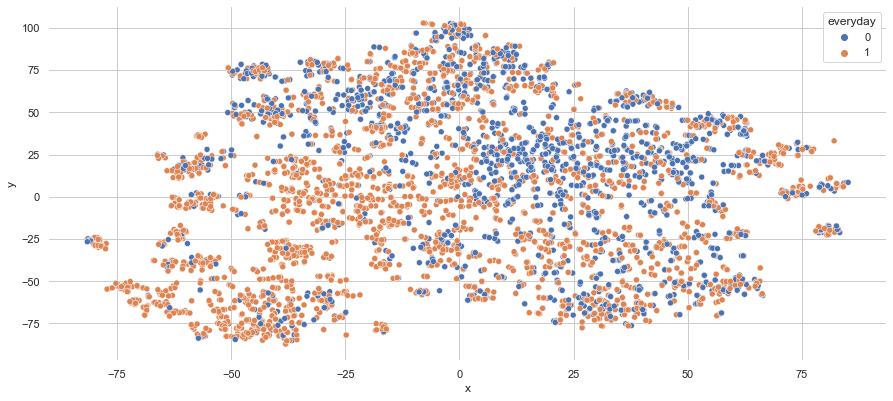

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# variables in the dataset
f, ax = plt.subplots(figsize=(15, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(
    x="x", y="y", hue="everyday", data=embeddingsdf, ax=ax
)

-------------------------
## Random Forest Classifier

In [6]:
merged_df.groupby('category').count()

,statement_number,statement_x,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,elicitation,statement_y,fixed statement,embeddings
category,,,,,,,,,,,,
Culture and the arts,326,326,326,326,326,326,326,326,326,326,326,326
General reference,780,780,780,780,780,780,780,780,780,780,780,780
Geography and places,128,128,128,128,128,128,128,128,128,128,128,128
Health and fitness,266,266,266,266,266,266,266,266,266,266,266,266
History and events,112,112,112,112,112,112,112,112,112,112,112,112
Human activities,622,622,622,622,622,622,622,622,622,622,622,622
Mathematics and logic,93,93,93,93,93,93,93,93,93,93,93,93
Natural and physical sciences,162,162,162,162,162,162,162,162,162,162,162,162
People and self,909,909,909,909,909,909,909,909,909,909,909,909


Spliting the data into train and test sets then run random forest

In [85]:
for category in merged_df['category'].unique():
    X_train = merged_df[merged_df['category'] != category].embeddings
    y_train = merged_df[merged_df['category'] != category].behavior

    X_test = merged_df[merged_df['category'] == category].embeddings.to_numpy()
    y_test = merged_df[merged_df['category'] == category].behavior.to_numpy()

    rf = RandomForestClassifier()
    rf.fit(list(X_train), y_train)
    y_pred = rf.predict(list(X_test))
    accuracy = jaccard_score(y_test, y_pred)
    print(category, " Accuracy: ", accuracy)

Mathematics and logic  Accuracy:  0.6451612903225806
Health and fitness  Accuracy:  0.6578947368421053
Natural and physical sciences  Accuracy:  0.6666666666666666
Human activities  Accuracy:  0.747588424437299
General reference  Accuracy:  0.5884615384615385
Religion and belief systems  Accuracy:  0.5986842105263158
People and self  Accuracy:  0.8063806380638063
Technology and applied sciences  Accuracy:  0.5128205128205128
Society and social sciences  Accuracy:  0.9474835886214442
History and events  Accuracy:  0.5267857142857143
Philosophy and thinking  Accuracy:  0.8633540372670807
Culture and the arts  Accuracy:  0.5276073619631901
Geography and places  Accuracy:  0.5390625


In [138]:
def do_global_r_sqaured(actual_values, model_predictions):
    # Calculate MSE for model and baseline
    baseline_predictions = [mode(actual_values)] * len(actual_values)
    mse_model = mean_squared_error(actual_values, model_predictions)
    mse_baseline = mean_squared_error(actual_values, baseline_predictions)

    # Calculate Global R-squared
    global_r_squared = 1 - (mse_model / mse_baseline)

    print(f'Mean Squared Error (Model): {mse_model}')
    print(f'Mean Squared Error (Baseline): {mse_baseline}')
    print(f'Global R-squared: {global_r_squared}')

In [ ]:
outcomes = ['behavior', 'everyday', 'figure_of_speech', 'judgment', 'opinion', 'reasoning']

for outcome in outcomes:
    X_train = merged_df[merged_df['category'] != 'Society and social sciences'].embeddings
    y_train = merged_df[merged_df['category'] != 'Society and social sciences'][outcome]

    X_test = merged_df[merged_df['category'] == 'Society and social sciences'].embeddings
    y_test = merged_df[merged_df['category'] == 'Society and social sciences'][outcome]

    rf = RandomForestClassifier()
    rf.fit(list(X_train), y_train)
    y_pred = rf.predict(list(X_test))
    accuracy = jaccard_score(y_test, y_pred)
    print(outcome, "- Accuracy:", accuracy)
    do_global_r_sqaured(y_test, y_pred)
    print('----------------------------')

## XGBoost

In [48]:

for outcome in outcomes:
    X_train = merged_df[merged_df['category'] != 'Society and social sciences'].embeddings.to_numpy()
    y_train = merged_df[merged_df['category'] != 'Society and social sciences'][outcome]

    X_test = merged_df[merged_df['category'] == 'Society and social sciences'].embeddings
    y_test = merged_df[merged_df['category'] == 'Society and social sciences'][outcome]

    dtrain = xgb.DMatrix(np.vstack(X_train), label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(np.vstack(X_test), label=y_test, enable_categorical=True)
    
    params = {
        "objective": "binary:logistic",
        "max_depth": 3,  
        "learning_rate": 0.1
    }

    n = 100

    model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=n,
    )

    preds = model.predict(dtest)

    print(outcome)
    do_global_r_sqaured(y_test, preds)

behavior
Mean Squared Error (Model): 0.11371604070025852
Mean Squared Error (Baseline): 0.045951859956236324
Global R-squared: -1.4746776476199117
everyday
Mean Squared Error (Model): 0.22471228478066843
Mean Squared Error (Baseline): 0.4288840262582057
Global R-squared: 0.4760534992614007
figure_of_speech
Mean Squared Error (Model): 0.06647939092147037
Mean Squared Error (Baseline): 0.0787746170678337
Global R-squared: 0.15608106524689003
judgment
Mean Squared Error (Model): 0.09436104483931075
Mean Squared Error (Baseline): 0.06345733041575492
Global R-squared: -0.4869999135022418
opinion
Mean Squared Error (Model): 0.11335814963327051
Mean Squared Error (Baseline): 0.10065645514223195
Global R-squared: -0.12618857353053525
reasoning
Mean Squared Error (Model): 0.2354059302768994
Mean Squared Error (Baseline): 0.4726477024070022
Global R-squared: 0.5019420827011898


In [45]:
# Define hyperparameters
params = {
    "objective": "binary:logistic",
    "max_depth": 3,  
    "learning_rate": 0.1
}

n = 100

model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

preds = model.predict(dtest)

do_global_r_sqaured(y_test, preds)

In [46]:
preds

array([0.5513926 , 0.63500744, 0.8711003 , 0.9280181 , 0.7691742 ,
       0.5081068 , 0.6342565 , 0.69798386, 0.70887953, 0.76032114,
       0.7780644 , 0.67430806, 0.7777077 , 0.72518116, 0.6964074 ,
       0.56942475, 0.783343  , 0.5788355 , 0.55333483, 0.7435953 ,
       0.765805  , 0.7316966 , 0.6351676 , 0.7332892 , 0.675165  ,
       0.53415906, 0.3778532 , 0.6251968 , 0.5572829 , 0.7151871 ,
       0.6123967 , 0.74304515, 0.67549264, 0.65214986, 0.545905  ,
       0.78630805, 0.72232753, 0.5149935 , 0.6753522 , 0.83459884,
       0.48986483, 0.60221285, 0.74860305, 0.714236  , 0.7745888 ,
       0.42819548, 0.42683434, 0.84305006, 0.44031626, 0.728522  ,
       0.75557184, 0.6138055 , 0.7969557 , 0.60070235, 0.7167251 ,
       0.5629116 , 0.70209384, 0.89316744, 0.6994382 , 0.81649363,
       0.5754485 , 0.5432339 , 0.76022977, 0.72770417, 0.92340726,
       0.77325565, 0.6427894 , 0.75400263, 0.64704955, 0.50671095,
       0.5590861 , 0.71225184, 0.54473853, 0.7751772 , 0.93819

In [47]:
do_global_r_sqaured(y_test, preds)

Mean Squared Error (Model): 0.11371604070025852
Mean Squared Error (Baseline): 0.045951859956236324
Global R-squared: -1.4746776476199117


In [46]:
def label_statement(statement):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {
                "role": "system",
                "content": 'You are a bot that take a statement from user and give the properties of the statement based on the following definitions, don\'t explain your answer and answer in JSON format ({\n"behavior": ,\n"everyday":,\n"figure_of_speech",\n"judgment":,\n"opinion":,\n"reasoning":,\n"knowledge category": \n}). Dimensions of statement and their definition:\nIs it behavior?\nyest: it refers to beliefs, perceptions, preferences, and socially con-structed rules that govern human experience; it can be “real” or opinion, but is intrinsically of human origins. e.g., I exist and am the same person I was yesterday. He yelled at me because he was angry. There are seven days in the week.\nno: it refers to objective features of the world as described by, say, physics, biology, engineering, mathematics or other natural rules; it can be measured empirically, or derived logically. e.g., Men on average are taller than women. The Earth is the third planet from the Sun. Ants are smaller than Elephants.\n\nIs it everyday?\nyes: people encounter, or could encounter, situations like this in the course of their ordinary, everyday experiences, e.g., Touching a hot stove will burn you. Commuting at rush hour takes longer. It is rude to jump the line.\nno: this claim refers to regularities or conclusions that cannot be observed or arrived at solely through individual experience, e.g., Capitalism is a better economic system than Communism. Strict gun laws save lives. God exists\n\nIs it figure_of_speech?\nyes: it contains an aphorism, metaphor, hyperbole, e.g., Birds of a feather flock together. A friend to all is a friend to none.\nno: it is plain and ordinary language that means exactly what it says. e.g. The sky is blue. Elephants are larger than dogs. Abraham Lincoln was a great president.\n\nis it judgment?\nyes: it refers to a judgment, belief, value, social norm or convention. e.g., If you are going to the office, you should wear business attire,not a bathing suit. Treat others how you want them to treat you. Freedom is a fundamental human right.\nno: it refers to something in the world such as an empirical regularity or scientific law, e.g., hot things will burn you; the sun rises in the east and sets in the west.\n\nIs it opinion?\nyes: it is something that someone might think is true, or wants others to think is true, but can’t be demonstrated to be objectively correct or incorrect; it is inherently subjective. e.g., FDR was the greatest US president of the 20th Century.. The Brooklyn Bridge is prettier than the Golden Gate. Vaccine mandates are a tolerable imposition on individual freedom.\nno: it is something that can be demonstrated to be correct or incorrect, independently of anyone’s opinion, e.g., the earth is the third planet from the sun (this is correct and we know it is correct), Obama was the 24th president of the United States (this is incorrect, but we know it’s incorrect). It will be sunny next Tuesday (we don’t yet know if this is correct, but we will be able to check in the future).\n\nIs it reasoning?\nyes: the claim presents a conclusion that is arrived at by combining knowledge and logic, e.g., The sun is in the east, therefore it is morning. My dog is wagging its tail, therefore it is happy. The glass fell off the table, therefore it will break and the floor will become wet.\nno: the claim refers to some observation about the world; it may be true or false, opinion or fact, subjective or objective e.g., The sun rises in the east and sets in the west. Dogs are nicer than cats. Glasses break when they are dropped.\n\nWhich knowledge category or categories describe this claim? (choose one that apply)\n    General reference\n    Culture and the arts\n    Geography and places\n    Health and fitness\n    History and events\n    Human activities\n    Mathematics and logic\n    Natural and physical sciences\n    People and self\n    Philosophy and thinking\n    Religion and belief systems\n    Society and social sciences\n    Technology and applied sciences\n',
            },
            {
                "role": "user",
                "content": statement,
            },
        ],
        temperature=0,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )

    return response

In [72]:
first_500_statements = []

for s in merged_df['statement_y'].head(500).values:
    first_500_statements.append(label_statement(s))

In [85]:
df_data = []

for _ in first_500_statements:
    df_data.append(json.loads(_['choices'][0]['message']['content']))

df_0_to_500 = pd.DataFrame(df_data)
df_0_to_500['statement_index'] = df_0_to_500.index + 1
df_0_to_500

,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,no,yes,no,no,no,no,Mathematics and logic,1
1,no,yes,no,no,no,no,Mathematics and logic,2
2,no,yes,no,yes,no,no,Health and fitness,3
3,no,yes,no,no,no,no,Natural and physical sciences,4
4,yes,yes,no,yes,no,no,Human activities,5
...,...,...,...,...,...,...,...,...
95,yes,yes,no,yes,yes,no,People and self,96
96,yes,yes,no,yes,yes,no,People and self,97
97,yes,yes,no,yes,yes,no,People and self,98
98,yes,yes,no,yes,yes,no,Human activities,99


In [100]:
fivehundred_1000_statements = []

for s in tqdm(merged_df['statement_y'].values[500:1000]):
    fivehundred_1000_statements.append(label_statement(s))

100%|██████████| 500/500 [28:00<00:00,  3.36s/it]


In [104]:
df_data = []

for _ in fivehundred_1000_statements:
    df_data.append(json.loads(_['choices'][0]['message']['content']))

df_500_to_1000 = pd.DataFrame(df_data)
df_500_to_1000['statement_index'] = df_500_to_1000.index + 501
df_500_to_1000


,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,no,yes,yes,no,no,no,Natural and physical sciences,501
1,yes,no,no,yes,yes,no,Culture and the arts,502
2,yes,no,no,yes,yes,no,Society and social sciences,503
3,yes,yes,no,yes,yes,no,Philosophy and thinking,504
4,yes,yes,no,yes,yes,no,Religion and belief systems,505
...,...,...,...,...,...,...,...,...
495,yes,yes,no,yes,yes,no,Human activities,996
496,yes,no,yes,yes,yes,yes,Human activities,997
497,yes,yes,no,yes,yes,no,Human activities,998
498,yes,yes,no,yes,yes,yes,Human activities,999


In [114]:
thousand_1500_statements = []

for s in tqdm(merged_df['statement_y'].values[1000:1500]):
    thousand_1500_statements.append(label_statement(s))

100%|██████████| 365/365 [21:43<00:00,  3.57s/it]


In [115]:
df_data = []

for _ in thousand_1500_statements:
    df_data.append(json.loads(_['choices'][0]['message']['content']))

df_1000_to_1500 = pd.DataFrame(df_data)
df_1000_to_1500['statement_index'] = df_1000_to_1500.index + 1001
df_1000_to_1500


,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,yes,yes,no,no,no,no,Human activities,1001
1,no,yes,no,no,no,yes,People and self,1002
2,no,yes,no,no,no,yes,Human activities,1003
3,yes,yes,no,yes,yes,yes,Human activities,1004
4,yes,yes,no,yes,yes,yes,People and self,1005
...,...,...,...,...,...,...,...,...
495,yes,yes,no,no,no,yes,Health and fitness,1496
496,yes,yes,no,yes,yes,yes,Human activities,1497
497,yes,yes,no,no,yes,yes,Society and social sciences,1498
498,yes,yes,no,yes,yes,no,Human activities,1499


In [117]:
thousandfive_2000_statements = []

for s in tqdm(merged_df['statement_y'].values[1500:2000]):
    thousandfive_2000_statements.append(label_statement(s))

100%|██████████| 500/500 [28:24<00:00,  3.41s/it]


In [118]:
df_data = []

for _ in thousandfive_2000_statements:
    df_data.append(json.loads(_['choices'][0]['message']['content']))

df_1500_to_2000 = pd.DataFrame(df_data)
df_1500_to_2000['statement_index'] = df_1500_to_2000.index + 1501
df_1500_to_2000


,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,yes,no,no,yes,yes,yes,Society and social sciences,1501
1,yes,yes,no,no,no,yes,Human activities,1502
2,yes,yes,no,no,no,yes,Human activities,1503
3,yes,yes,no,yes,yes,yes,Human activities,1504
4,yes,yes,no,yes,yes,no,Health and fitness,1505
...,...,...,...,...,...,...,...,...
495,yes,yes,no,yes,yes,yes,People and self,1996
496,yes,yes,no,yes,yes,yes,People and self,1997
497,yes,yes,no,yes,yes,yes,Human activities,1998
498,yes,yes,no,yes,yes,yes,People and self,1999


In [122]:
rating_df = pd.concat([df_0_to_500, df_500_to_1000, df_1000_to_1500, df_1500_to_2000], axis=0).reset_index(drop=True)
rating_df.head(5)

,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,no,yes,no,no,no,no,Mathematics and logic,1
1,no,yes,no,no,no,no,Mathematics and logic,2
2,no,yes,no,yes,no,no,Health and fitness,3
3,no,yes,no,no,no,no,Natural and physical sciences,4
4,yes,yes,no,yes,no,no,Human activities,5


In [130]:
# assuming the dataframe is named "df"
new_columns = {}
for col in rating_df.columns:
    if col != "statement_index":
        new_columns[col] = f"gpt_{col}"

gpt_rating_df = rating_df.rename(columns=new_columns)


In [131]:

gpt_rating_df = pd.concat([merged_df.head(2000), gpt_rating_df], axis=1)
for col in ['gpt_behavior', 'gpt_everyday', 'gpt_figure_of_speech', 'gpt_judgment', 'gpt_opinion', 'gpt_reasoning']:
    gpt_rating_df[col] = gpt_rating_df[col].replace({'yes': 1, 'no': 0})


In [142]:
outcomes = ['behavior', 'everyday', 'figure_of_speech', 'judgment', 'opinion', 'reasoning']

for o in outcomes:
    print(o)
    do_global_r_sqaured(gpt_rating_df[o].values, gpt_rating_df[f'gpt_{o}'].values)

behavior
Mean Squared Error (Model): 0.3225
Mean Squared Error (Baseline): 0.357
Global R-squared: 0.09663865546218486
everyday
Mean Squared Error (Model): 0.323
Mean Squared Error (Baseline): 0.342
Global R-squared: 0.05555555555555558
figure_of_speech
Mean Squared Error (Model): 0.1665
Mean Squared Error (Baseline): 0.186
Global R-squared: 0.10483870967741926
judgment
Mean Squared Error (Model): 0.3295
Mean Squared Error (Baseline): 0.3005
Global R-squared: -0.09650582362728799
opinion
Mean Squared Error (Model): 0.314
Mean Squared Error (Baseline): 0.376
Global R-squared: 0.16489361702127658
reasoning
Mean Squared Error (Model): 0.3035
Mean Squared Error (Baseline): 0.269
Global R-squared: -0.12825278810408913


In [139]:
do_global_r_sqaured(gpt_rating_df.behavior.values, gpt_rating_df.gpt_behavior.values)

Mean Squared Error (Model): 0.3225
Mean Squared Error (Baseline): 0.357
Global R-squared: 0.09663865546218486
